# Univariate analysis
## Research question: Is Type 2 diabetes (T2D) more prevalent in critical COVID-19 cases than non-critical cases? 
-	Independent variable (predictor): Diabetes status (T2 vs no T2)
-	Dependent variable (outcome): COVID-19 severity (critical vs non-critical)

H₀: There is no difference in the prevalence of Type 2 diabetes between critical and non-critical COVID-19 cases.

H₁: Type 2 diabetes is more prevalent in critical COVID-19 cases than in non-critical cases.


In [140]:
# ================================================================
# 0. IMPORT LIBRARIES 
# ================================================================
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [142]:
# ================================================================
# 1. YOUR MISSING-VALUE PREPROCESSING
# ================================================================

# Define all the "missing value" indicators
missing_values = ["", "unknown", "Unknown"]

# Load the dataset and convert these to NaN automatically
combined_dataset_df = pd.read_csv("combined_dataset.csv", na_values=missing_values)

# Count missing values per column
missing_count = combined_dataset_df.isnull().sum()
missing_count = missing_count[missing_count > 0]
print("Missing values per column:")
print(missing_count)

# Save dataset with explicit 'NaN' in the CSV
combined_dataset_df.to_csv("NaN-missing values.csv", index=False, na_rep="NaN")

Missing values per column:
ihd                              24
smoking                           8
cause_eskd                       51
WHO_severity                     53
fatal_disease                    53
radiology_evidence_covid         53
time_from_first_symptoms         82
time_from_first_positive_swab    53
dtype: int64


In [143]:
# ================================================================
# 2. CREATE YOUR SMALL UNIVARIATE DATASET (We continue analysis from this dataset)
# ================================================================
univariate_df = combined_dataset_df[
    ["individual_id", "diabetes", "WHO_severity"]
]

univariate_df.to_csv("univariate_dataset.csv", index=False)

print("\nInitial univariate dataset preview:")
print(univariate_df.head())


Initial univariate dataset preview:
  individual_id diabetes WHO_severity
0          C101   yes.T2          NaN
1          C101   yes.T2       severe
2          C101   yes.T2       severe
3          C101   yes.T2       severe
4          C101   yes.T2       severe


In [144]:
# ================================================================
# 3. CLEAN DIABETES AND WHO-SEVERITY VARIABLES
# ================================================================
df = univariate_df.copy()

# 3.1 Clean diabetes 
df["T2_diabetes"] = df["diabetes"].astype(str).str.lower().str.strip().map({"yes.t2":1, "no":0})

print("\nDiabetes cleaned value counts:")
print(df["T2_diabetes"].value_counts(dropna=False))


Diabetes cleaned value counts:
T2_diabetes
1.0    148
0.0     92
NaN      1
Name: count, dtype: int64


In [145]:
# 3.2 Clean WHO severity 
df["severity_num"] = df["WHO_severity"].astype(str).str.lower().str.strip().map({"mild":1, "moderate":2, "severe":3, "critical":4})

print("\nWHO severity cleaned value counts:")
print(df["severity_num"].value_counts(dropna=False))


WHO severity cleaned value counts:
severity_num
1.0    69
NaN    53
3.0    52
4.0    34
2.0    33
Name: count, dtype: int64


In [146]:
# ================================================================
# 4. COLLAPSE REPEATED SAMPLES → ONE ROW PER PATIENT
# ================================================================
patient_df = (
    df.groupby("individual_id")
      .agg({
          "T2_diabetes": "max",
          "severity_num": "max"})
      .rename(columns={"severity_num": "peak_severity_num"})
      .reset_index()
)

# Add severity label
patient_df["peak_severity_label"] = patient_df["peak_severity_num"].map({1:"mild", 2:"moderate", 3:"severe", 4:"critical"})

# Binary: critical vs non-critical
patient_df["critical"] = (patient_df["peak_severity_num"] == 4).astype("Int64")

print("\nPatient-level dataset:")
print(patient_df.head())

patient_df.to_csv("univariate_patient_df_no_drop_out.csv", index=False, na_rep="NaN")
print("\nSaved patient-level univariate dataframe as: univariate_patient_df_no_drop_out.csv")


Patient-level dataset:
  individual_id  T2_diabetes  peak_severity_num peak_severity_label  critical
0          C101          1.0                3.0              severe         0
1          C103          1.0                NaN                 NaN         0
2          C104          0.0                NaN                 NaN         0
3          C106          1.0                NaN                 NaN         0
4          C108          0.0                3.0              severe         0

Saved patient-level univariate dataframe as: univariate_patient_df_no_drop_out.csv


In [147]:
# ================================================================
# 5. DROP PATIENTS WITH MISSING DIABETES OR SEVERITY
# ================================================================

# Count patients BEFORE filtering
before_n = len(patient_df)

# Count missing diabetes and missing severity BEFORE filtering
missing_diabetes_n = patient_df["T2_diabetes"].isna().sum()
missing_severity_n = patient_df["peak_severity_num"].isna().sum()

# Drop patients with missing diabetes or missing severity
patient_df = patient_df.dropna(subset=["T2_diabetes", "peak_severity_num"])

# Convert diabetes to integer (safe now because no NaNs remain)
patient_df["T2_diabetes"] = patient_df["T2_diabetes"].astype(int)
# Count AFTER filtering
after_n = len(patient_df)

# Total excluded
excluded_n = before_n - after_n

# ------------------------------
# PRINT SUMMARY
# ------------------------------
print("Patient Filtering Summary:")
print("- Patients BEFORE filtering:", before_n)
print("- Missing diabetes:", missing_diabetes_n)
print("- Missing WHO severity:", missing_severity_n)
print("- TOTAL excluded:", excluded_n)
print("- Patients AFTER filtering:", after_n)

Patient Filtering Summary:
- Patients BEFORE filtering: 91
- Missing diabetes: 1
- Missing WHO severity: 37
- TOTAL excluded: 37
- Patients AFTER filtering: 54


In [148]:
# ------------------------------
# SAVE AND SHOW THE FILTERED DATAFRAME
# ------------------------------
patient_df.to_csv("univariate_patient_df_with_drop_out.csv", index=False, na_rep="NaN")

print("Filtered patient-level dataframe (after exclusions):")
display(patient_df.head(10))    # show first 10 patients

Filtered patient-level dataframe (after exclusions):


,individual_id,T2_diabetes,peak_severity_num,peak_severity_label,critical
0,C101,1,3.0,severe,0
4,C108,0,3.0,severe,0
5,C110,0,2.0,moderate,0
6,C113,1,3.0,severe,0
7,C116,0,4.0,critical,1
8,C123,1,3.0,severe,0
9,C124,0,2.0,moderate,0
10,C126,0,1.0,mild,0
11,C127,1,2.0,moderate,0
12,C128,1,1.0,mild,0


In [149]:
# ================================================================
# 6. CONTINGENCY TABLE (T2 vs CRITICAL)
# ================================================================
ct = pd.crosstab(patient_df["T2_diabetes"], patient_df["critical"])
ct.index = ["no_T2", "T2"]
ct.columns = ["not_critical", "critical"]

print("\nContingency table:")
print(ct)


Contingency table:
       not_critical  critical
no_T2            16         6
T2               25         7


In [150]:
# ================================================================
# 7. FISHER’S EXACT TEST 
# ================================================================
from scipy.stats import fisher_exact
# Fisher's exact test
oddsratio, p_fisher = fisher_exact(ct.values)
# Extract counts
a, b, c, d = ct.values.flatten()

# Compute log(OR) and its SE
log_or = np.log(oddsratio)
se = np.sqrt(1/a + 1/b + 1/c + 1/d)

# 95% CI
ci_lower = np.exp(log_or - 1.96 * se)
ci_upper = np.exp(log_or + 1.96 * se)

print(f"Fisher Exact Test: p={p_fisher:.4f}, Odds Ratio={oddsratio:.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})")

Fisher Exact Test: p=0.7500, Odds Ratio=0.747, 95% CI=(0.212, 2.627)


In [151]:
# ================================================================= ========
#8. Chi-square (χ²) TEST
# ================================================================= ========
from scipy.stats import chi2_contingency  # ← IMPORT THIS

obs = ct.values                                          # observed table
chi2, p_chi2, dof, expected = chi2_contingency(obs)      # run χ² test

print("\n===== EXTENDED CHI-SQUARE ANALYSIS =====")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_chi2:.4f}")

# -------------------------------------------------
# 8.1 Observed vs Expected table
# -------------------------------------------------
obs_df = pd.DataFrame(obs, index=ct.index, columns=ct.columns)
exp_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
print("\nObserved counts:")
print(obs_df)
print("\nExpected counts:")
print(exp_df)

# -------------------------------------------------
# 8.2 Cell-wise χ² contribution
# -------------------------------------------------
chi_contrib = (obs - expected)**2 / expected
chi_contrib_df = pd.DataFrame(chi_contrib, index=ct.index, columns=ct.columns)

print("\nChi-square contribution per cell:")
print(chi_contrib_df)

# -------------------------------------------------
# 8.3 Standardized residuals
# (Shows which cells deviate most from what is expected)
# -------------------------------------------------
std_residuals = (obs - expected) / np.sqrt(expected)
std_residuals_df = pd.DataFrame(std_residuals, index=ct.index, columns=ct.columns)
print("\nStandardized residuals:")
print(std_residuals_df)

# -------------------------------------------------
# 8.4 Effect size: Cramér’s V
# -------------------------------------------------
n = obs.sum()
cramers_v = np.sqrt(chi2 / (n * (min(obs_df.shape) - 1)))

print(f"\nCramér's V (effect size): {cramers_v:.4f}")





===== EXTENDED CHI-SQUARE ANALYSIS =====
Chi-square statistic: 0.0174
Degrees of freedom: 1
p-value: 0.8950

Observed counts:
       not_critical  critical
no_T2            16         6
T2               25         7

Expected counts:
       not_critical  critical
no_T2     16.703704  5.296296
T2        24.296296  7.703704

Chi-square contribution per cell:
       not_critical  critical
no_T2      0.029646  0.093499
T2         0.020382  0.064281

Standardized residuals:
       not_critical  critical
no_T2     -0.172180  0.305776
T2         0.142764 -0.253536

Cramér's V (effect size): 0.0180


In [152]:
# =========================================================================
#9. Interpretation of Fisher's exact test and Chi-square test
# =========================================================================
print("For the Fisher's exact test:")
print("Fisher Exact Test p-value is 0.750 meaning that there is no statistically significant association between T2D and having critical COVID-19.")
print("Odds Ratio is 0.747, OR < 1 means: patients with T2D had lower odds of being critical compared to non-diabetics.")
print ("Conclusion: There is no evidence of a relationship between T2D and critical outcome.\n")

print("Confirmation with the Chi-square test:")
print("Expected counts per cell:")
print("  no_T2, not_critical = 16.70")
print("  no_T2, critical     = 5.30")
print("  T2, not_critical    = 24.30")
print("  T2, critical        = 7.70")
print("Interpretation: The expected values closely matched the observed values, suggesting minimal deviation from what would occur by chance alone.\n")

print("Standardized residuals per cell:")
print("  no_T2, not_critical = -0.172")
print("  no_T2, critical     = 0.306")
print("  T2, not_critical    = 0.143")
print("  T2, critical        = -0.254")
print("Interpretation: All standardized residuals are small (|residual| < 2), indicating no cell contributes strongly to the chi-square statistic.\n")

print("Effect size (Cramér's V)= 0.0180")
print("Interpretation: Cramér's V is very small, suggesting a negligible association between T2D and critical COVID-19 outcome.\n")

print("Chi-square test summary:")
print("  Chi-square statistic = 0.0174")
print("  Degrees of freedom   = 1")
print("  p-value              = 0.8950")
print("Interpretation: With 1 degree of freedom, this p-value indicates no significant difference between observed and expected counts.")
print("Conclusion: The χ² test confirms there is no statistically significant association between T2D and critical status in your sample.\n")




For the Fisher's exact test:
Fisher Exact Test p-value is 0.750 meaning that there is no statistically significant association between T2D and having critical COVID-19.
Odds Ratio is 0.747, OR < 1 means: patients with T2D had lower odds of being critical compared to non-diabetics.
Conclusion: There is no evidence of a relationship between T2D and critical outcome.

Confirmation with the Chi-square test:
Expected counts per cell:
  no_T2, not_critical = 16.70
  no_T2, critical     = 5.30
  T2, not_critical    = 24.30
  T2, critical        = 7.70
Interpretation: The expected values closely matched the observed values, suggesting minimal deviation from what would occur by chance alone.

Standardized residuals per cell:
  no_T2, not_critical = -0.172
  no_T2, critical     = 0.306
  T2, not_critical    = 0.143
  T2, critical        = -0.254
Interpretation: All standardized residuals are small (|residual| < 2), indicating no cell contributes strongly to the chi-square statistic.

Effect size

<Figure size 600x500 with 0 Axes>

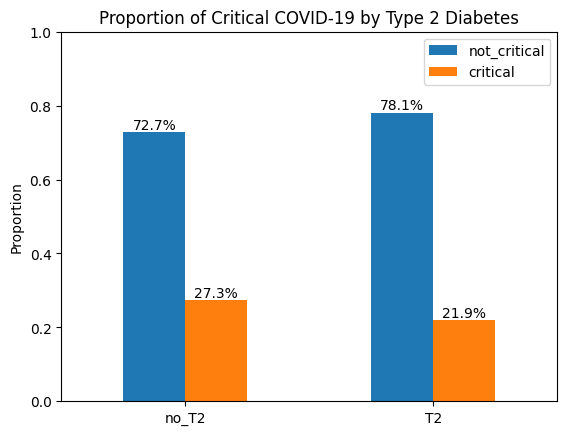

Critical: 21.9% of T2 patients vs. 27.3% of non-diabetics.
Non-critical: 78.1% of T2 patients vs. 72.7% of non-diabetics.


In [153]:
# ================================================================
# 10. VISUALIZATION — PROPORTION PLOT
# A proportion plot shows: % of T2D patients who become critical vs. % of non-diabetics who become critical
# ================================================================
import matplotlib.pyplot as plt

prop = ct.div(ct.sum(axis=1), axis=0)

plt.figure(figsize=(6,5))
ax = prop.plot(kind="bar", rot=0)

# Add labels above bars
for container in ax.containers:
    ax.bar_label(container, labels=[f"{v*100:.1f}%" for v in container.datavalues])

plt.ylim(0, 1)
plt.ylabel("Proportion")
plt.title("Proportion of Critical COVID-19 by Type 2 Diabetes")
plt.show()

critical = prop["critical"]
non_critical = prop["not_critical"]

print(f"Critical: {critical['T2']:.1%} of T2 patients vs. {critical['no_T2']:.1%} of non-diabetics.")
print(f"Non-critical: {non_critical['T2']:.1%} of T2 patients vs. {non_critical['no_T2']:.1%} of non-diabetics.")

In [165]:
# ================================================================
# 11. SAVE OUTPUTS
# ================================================================
patient_df.to_csv("univariate_patient_level_summary.csv", index=False)
ct.to_csv("univariate_patient_level_contingency.csv")